# Ma 17

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants
import sympy as sym
from sympy import sympify
import scipy.stats as stats

In [38]:
#Prints a value with its error in scientific notation up to its 2 decimal
def print_scientific(value,error):
    """
    value (float) : the value
    error (float) : the error
    
    Returns:
        (string) : formatted string with the value an error
    """
    base10_error=int(np.floor(np.log10(error)))
    base10_value=int(np.floor(np.log10(np.abs(value))))
    digits=int(base10_value-base10_error+1)
    if digits<=0:
        digits=0
    base=10**base10_value
    string=f"({value/base:.{digits}f} ± {error/base:.{digits}f})·10^{base10_value}"
    return string

In [39]:
def compute_error(expression, variables, values, errors):
    """
    expression (string) : expression you used to compute the value
    variables  (list of strings) : list of variables that are in the expression in string form
    values     (list of float)   : list of values that go in the expression
    errors     (list of float)   : list of errors for each value
    
    Returns: (result, uncertainty) : tuple with the desired value and its uncertainty
    
    !! ATTENTION: Length variables = length values = length errors
    
    An example: 
    >   expression="x**2+y"
    >   var=["x","y"]; values=[2,1]; errors=[4,2]
    >   compute_error(expression, var, values, errors)
    """
    #Make variables and expression symbolic
    expression=sym.sympify(expression)
    variables=sym.symbols(variables)
    
    #To store coefficients
    coefficients=[]
    
    for index,variable in enumerate(
        variables):
        dexpression=sym.diff(expression, variable) #Differentiates expression
        coefficient=dexpression.subs(list(zip(variables, values))) #substitution
        coefficients.append(errors[index]*np.float64(coefficient)) #multiply coefficient times error
    
    uncertainty=np.sqrt(np.sum(np.array(coefficients)**2))
    result=np.float64(expression.subs(list(zip(variables, values))))

    return result,uncertainty
    

## Computing mass of monolayer Cys

Text(0, 0.5, 'Frequency (Hz)')

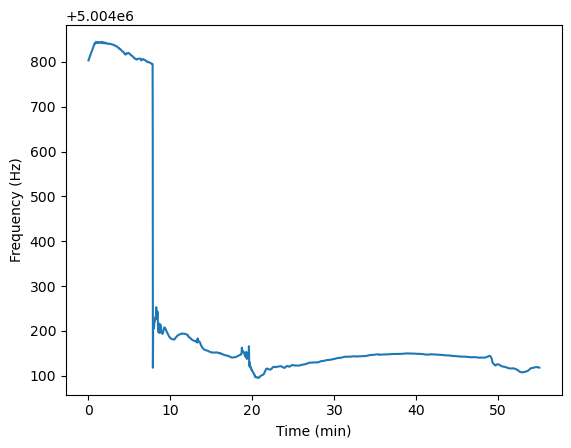

In [40]:
#Load dataframe
df=pd.read_csv(f"data/cys-air.csv", sep=";")
frequency=np.array(df["Frequency"])
time=np.array(df["Time (s)"])
plt.plot(time/60, frequency)
plt.xlabel("Time (min)")
plt.ylabel("Frequency (Hz)")

The first part corresponds to oscillations in the air. After the 20 minute mark the cytochrome protein was added. 

In [41]:
time_slice=[time>=9*60 and time<=19*60 for time in time]

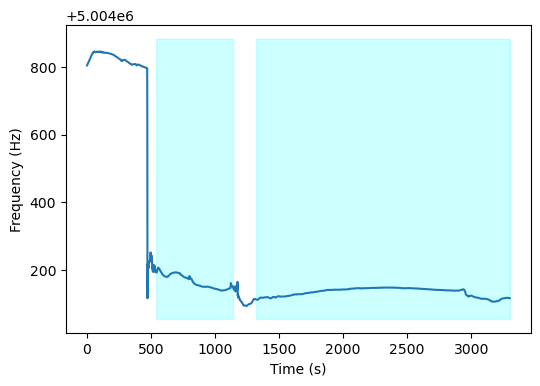

In [42]:
diff=np.max(frequency)-np.min(frequency)
fig, axis=plt.subplots(1,1,figsize=(6,4))
axis.plot(time, frequency)
axis.set_xlabel("Time (s)"); axis.set_ylabel("Frequency (Hz)")
axis.fill_between(time, np.min(frequency)-diff*0.05, np.max(frequency)+diff*0.05, where=time_slice, alpha=0.2, color="cyan",
                 label="Air measurements")
axis.fill_between(time, np.min(frequency)-diff*0.05, np.max(frequency)+diff*0.05, where=time>=22*60,
                                                                                         alpha=0.2, color="cyan",
                 label="Air measurements")

### Selecting the slice

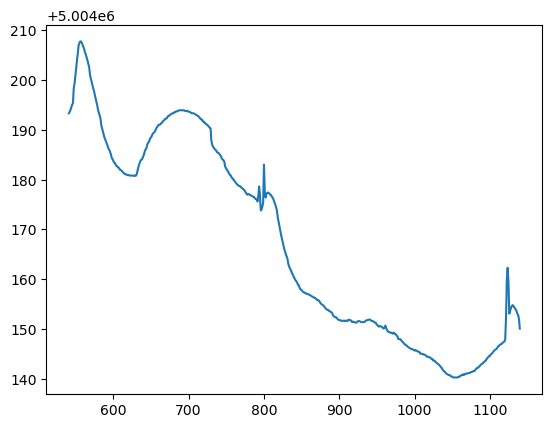

In [43]:
plt.plot(time[time_slice],frequency[time_slice])

In [44]:
time_MUA=time[time_slice]; freq_MUA=frequency[time_slice]

### (!!!) This section is wrong because there is no more MUA in the solution and the properties have changed (!!!)

In [45]:
#Previous results
rho_q=2.648*(constants.gram)*(constants.centi)**(-3)
stdrho_q=0.001*(constants.gram)*(constants.centi)**(-3)
deltaf_L, stddeltaf_L=np.load("results/task1/Deltaf_experimental.npy")
d_q, stdd_q=np.load("results/task1/d_q.npy")
f_0, stdf_0=np.load("results/task1/eigenfreq_air.npy")
A=np.pi*(constants.inch/2)**2
deltaf_L=-deltaf_L
linregression_eth=np.load("results/task2/linregression_eth.npy")
linregression_ethslope,linregression_ethintercept, linregression_ethr2,linregression_ethpvalue,linregression_ethstderr, linregression_ethintercept_stderr=linregression_eth

In [46]:
deltaf_MUA=freq_MUA-(linregression_ethslope*time_MUA+linregression_ethintercept)
mass=-(rho_q*d_q*A)/(f_0)*(deltaf_MUA)

In [47]:
stddeltaf_MUA=np.sqrt((time_MUA*linregression_ethstderr)**2+linregression_ethintercept_stderr**2)

In [48]:
expression="-(rho_q*d_q*A)/(f_0)*(deltaf_MUA)"
variables=["rho_q","d_q","A","f_0","deltaf_MUA"]
mass_MUA=[];stdmass_MUA=[]
for index,deltaf in enumerate(deltaf_MUA):
    mass, stdmass=compute_error(expression,variables,[rho_q,d_q,A,f_0,deltaf],
                  [stdrho_q,stdd_q,A*0.1,stdf_0,stddeltaf_MUA[index]])
    mass_MUA.append(mass);stdmass_MUA.append(stdmass)
mass_MUA=np.array(mass_MUA); stdmass_MUA=np.array(stdmass_MUA)

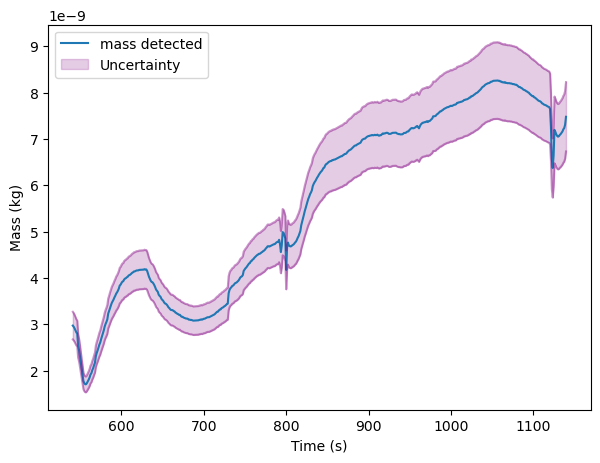

In [49]:
fig, axis=plt.subplots(1,1,figsize=(7,5))
axis.plot(time_MUA,mass_MUA, label="mass detected")
axis.plot(time_MUA,mass_MUA+stdmass_MUA, color="purple", alpha=0.4)
axis.plot(time_MUA,mass_MUA-stdmass_MUA, color="purple", alpha=0.4)
axis.fill_between(time_MUA, mass_MUA+stdmass_MUA, mass_MUA-stdmass_MUA,
                color="purple", alpha=0.2, label="Uncertainty")
axis.set_xlabel("Time (s)"); axis.set_ylabel("Mass (kg)")
axis.legend()

### Mass of the cys protein

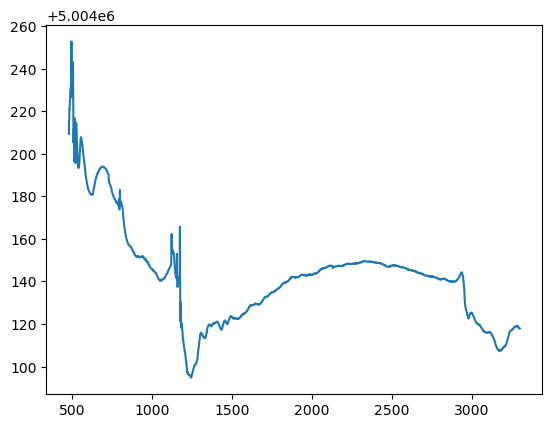

In [50]:
plt.plot(time[time>=8*60], frequency[time>=8*60])

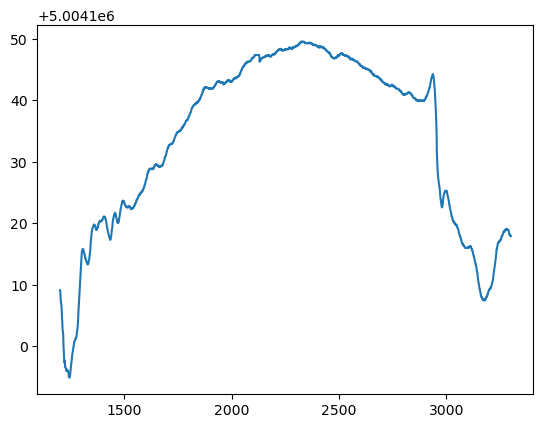

In [51]:
time_slice=time[time>=20*60]
freq_slice=frequency[time>=20*60]
plt.plot(time_slice,freq_slice)

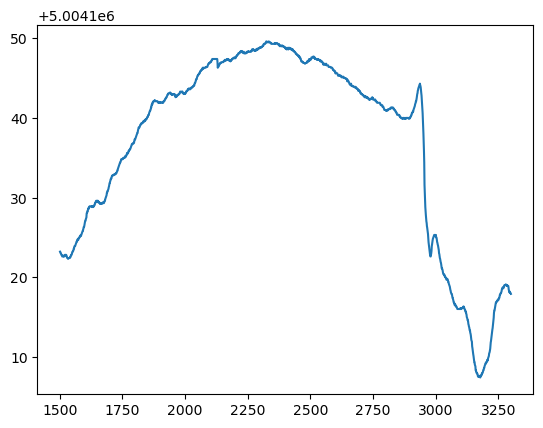

In [52]:
selection=[time>=1500 for time in time]
time_cys=time[selection]; freq_cys=frequency[selection]
plt.plot(time_cys, freq_cys)

In [53]:
#We load the mass values taken before
mass_MUA, stdmass_MUA=np.load("results/task2/mass_MUA.npy")

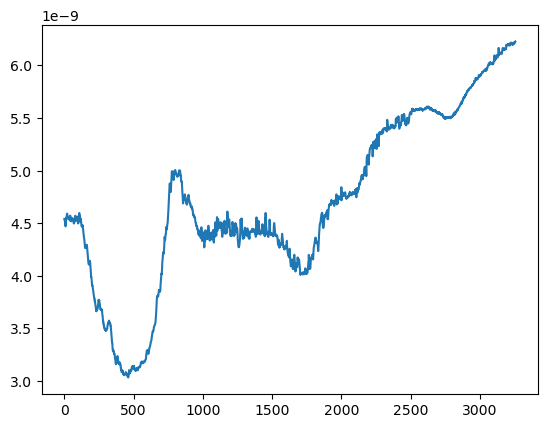

In [54]:
#We take the last value as the final mass for the MUA
finalmass_MUA, stdfinalmass_MUA= mass_MUA[-1], stdmass_MUA[-1]
plt.plot(mass_MUA)

In [55]:
#Rename the frequency to what it is, the frequency in the new buffer medium
freq_buffer=freq_MUA

In [56]:
deltaf_cys=freq_cys-np.mean(freq_buffer)
mass_total=-(rho_q*d_q*A)/(f_0)*(deltaf_cys)

In [57]:
stddeltaf_cys=np.sqrt(np.std(freq_buffer)**2+1)

In [58]:
expression=f"-(rho_q*d_q*A)/(f_0)*(deltaf_cys)"
variables=["rho_q","d_q","A","f_0","deltaf_cys", "finalmass_MUA"]
mass_cys=[];stdmass_cys=[]
for index,deltaf in enumerate(deltaf_cys):
    mass, stdmass=compute_error(expression,variables,[rho_q,d_q,A,f_0,deltaf, finalmass_MUA],
                  [stdrho_q,stdd_q,A*0.1,stdf_0,stddeltaf_cys, stdfinalmass_MUA])
    mass_cys.append(mass);stdmass_cys.append(stdmass)
mass_cys=np.array(mass_cys); stdmass_cys=np.array(stdmass_cys)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


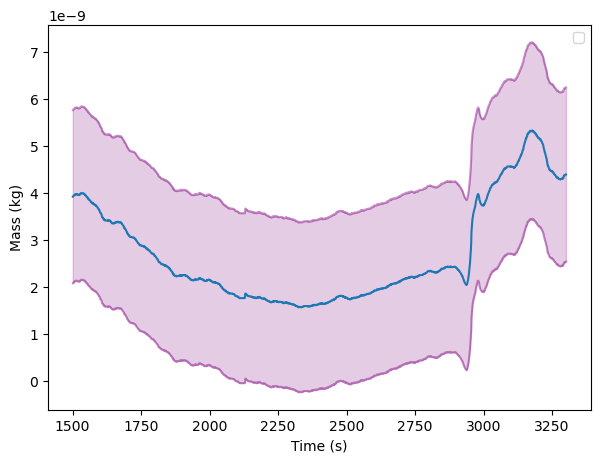

In [59]:
fig, axis=plt.subplots(1,1,figsize=(7,5))
axis.plot(time_cys,mass_cys)
axis.plot(time_cys,mass_cys+stdmass_cys, color="purple", alpha=0.4)
axis.plot(time_cys,mass_cys-stdmass_cys, color="purple", alpha=0.4)
axis.fill_between(time_cys, mass_cys+stdmass_cys, mass_cys-stdmass_cys,
                color="purple", alpha=0.2)
axis.set_xlabel("Time (s)"); axis.set_ylabel("Mass (kg)")
axis.legend()

### Detected molecules

In [60]:
atomicweight_cys = 12e3
weight_cys = atomicweight_cys * constants.physical_constants["atomic mass constant"][0]
molecules_cys = mass_cys / weight_cys
mols_cys = molecules_cys / constants.physical_constants["Avogadro constant"][0]
surface_cys = molecules_cys / A


In [61]:
weight_cys

1.99264687992e-23

In [62]:
avogadro = constants.physical_constants["Avogadro constant"][0]
expression = f"mass_cys/(weight_cys*A)"
variables = ["mass_cys", "weight_cys", "A"]
surface_cys = []
stdsurface_cys = []

for index, mass in enumerate(mass_cys):
    surface, stdsurface = compute_error(expression, variables, [mass, weight_cys, A],
                                        [stdmass_cys[index], weight_cys*0.001, A*0.1])
    surface_cys.append(surface)
    stdsurface_cys.append(stdsurface)

surface_cys = np.array(surface_cys)
stdsurface_cys = np.array(stdsurface_cys)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


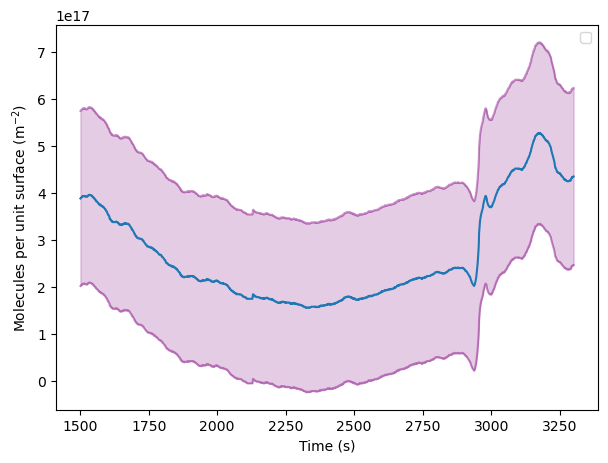

In [63]:
fig, axis = plt.subplots(1, 1, figsize=(7, 5))
axis.plot(time_cys, surface_cys)
axis.plot(time_cys, surface_cys + stdsurface_cys, color="purple", alpha=0.4)
axis.plot(time_cys, surface_cys - stdsurface_cys, color="purple", alpha=0.4)
axis.fill_between(time_cys, surface_cys + stdsurface_cys, surface_cys - stdsurface_cys,
                  color="purple", alpha=0.2)
axis.set_xlabel("Time (s)")
axis.set_ylabel("Molecules per unit surface (m$^{-2}$)")
axis.legend()

In [64]:
 print_scientific(np.mean(freq_buffer),np.sqrt(np.std(freq_buffer)+1))

'(5.0041672 ± 0.0000046)·10^6'

In [65]:
 print_scientific(mass,np.sqrt(np.std(freq_buffer)+1))

'(4 ± 4598639734)·10^-9'

## Plot combined results

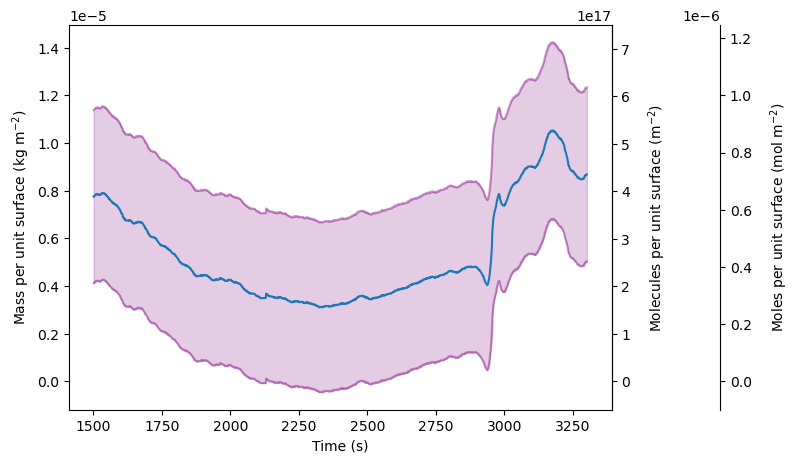

In [78]:
# Convert mass to molecules per unit surface
def mass_to_mol_per_units(m):
    return m / (weight_cys)

# Convert molecules per unit surface to mass
def mol_per_units_to_mass(mol):
    return mol * (weight_cys)

def mole_per_units_to_mass(mole):
    return mole * (weight_cys*avogadro)

def mass_to_mole_per_units(m):
    return m / (weight_cys*avogadro)

def rescale_mass(m):
    return m / A    

mass_pa_cys = rescale_mass(mass_cys)
stdmass_pa_cys = rescale_mass(stdmass_cys)

fig, ax = plt.subplots(1,1,figsize=(7,5))


ax.plot(time_cys,mass_pa_cyt)
ax.plot(time_cys,mass_pa_cyt+stdmass_pa_cyt, color="purple", alpha=0.4)
ax.plot(time_cys,mass_pa_cyt-stdmass_pa_cyt, color="purple", alpha=0.4)
ax.fill_between(time_cys, mass_pa_cys+stdmass_pa_cys, mass_pa_cys-stdmass_pa_cys,
                color="purple", alpha=0.2)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mass per unit surface (kg m$^{-2}$)")

ax2 = ax.secondary_yaxis('right', functions=(mass_to_mol_per_units, mol_per_units_to_mass))
ax2.set_ylabel('Molecules per unit surface (m$^{-2}$)', labelpad=12)

ax3 = ax.secondary_yaxis(1.2, functions=(mass_to_mole_per_units, mole_per_units_to_mass))
ax3.set_ylabel('Moles per unit surface (mol m$^{-2}$)', labelpad=12)




plt.show()


## Compute $f_L$ and $f_{L+M}$